# Segmenting the customer base by service usage patterns


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data visualization and pre-processing](#pre-processing)
* [Model Development](#Model_Development)

## Introduction: Business Problem

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case. 

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns. 

The target field, called __custcat__, has four possible values that correspond to the four customer groups, as follows:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service

Our objective is to build a classifier, to predict the class of unknown cases. We will use a specific type of classification called K nearest neighbour.


### Import the required libraries

In [1]:
import itertools

# scintific computing libraries
import pandas as pd                                     # data structure and tools       
import numpy as np                                      # arrays and matices
import scipy.optimize as opt                            # integrals, differential eq., optimization

# visualisation libraries
import matplotlib.pyplot as plt                         # plots and graphs               
import seaborn as sns                                   # plots: heat maps, time series, violin plots

import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing

%matplotlib inline

### Load Data From CSV File  

In [2]:
df = pd.read_csv('teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Data visualization and pre-processing

In [3]:
print(df.shape, '\n')
print(df.dtypes,'\n')
print(df.describe(include='all'))
df.head()

(1000, 12) 

region       int64
tenure       int64
age          int64
marital      int64
address      int64
income     float64
ed           int64
employ       int64
retire     float64
gender       int64
reside       int64
custcat      int64
dtype: object 

          region       tenure          age      marital      address  \
count  1000.0000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.0220    35.526000    41.684000     0.495000    11.551000   
std       0.8162    21.359812    12.558816     0.500225    10.086681   
min       1.0000     1.000000    18.000000     0.000000     0.000000   
25%       1.0000    17.000000    32.000000     0.000000     3.000000   
50%       2.0000    34.000000    40.000000     0.000000     9.000000   
75%       3.0000    54.000000    51.000000     1.000000    18.000000   
max       3.0000    72.000000    77.000000     1.000000    55.000000   

            income           ed       employ       retire       gender  \
count  1000.000000  

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


Let’s see how many of each class is in our data set 

In [4]:
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers

In [5]:
df.corr()['custcat'].sort_values()

region    -0.023771
gender    -0.004966
retire     0.008908
age        0.056909
address    0.067913
reside     0.082022
marital    0.083836
employ     0.110011
income     0.134525
tenure     0.166691
ed         0.193864
custcat    1.000000
Name: custcat, dtype: float64

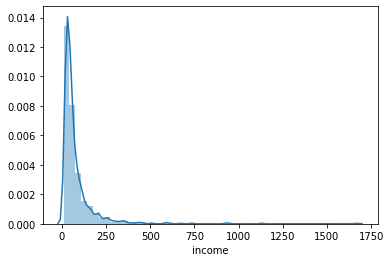

In [6]:
sns.distplot(df['income'])

In [7]:
q = df['income'].quantile(0.95)
df2 = df[df['income']<q]

In [8]:
df3 = df2.reset_index(drop=True)

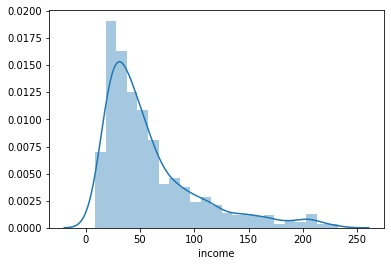

In [9]:
sns.distplot(df3['income'])

### Feature set

Lets define feature sets, X:

In [10]:
df3.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [11]:
X = df3[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ', 'retire', 'gender', 'reside']] .values
X[0:5]

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

In [12]:
y = df3['custcat'].values
y[0:5]

array([1, 4, 3, 1, 3], dtype=int64)

### Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:

In [13]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.01160668, -1.03042482,  0.24362718,  1.00210748, -0.22335106,
         0.0987529 ,  1.09324048, -0.54865469, -0.2281419 , -1.02559049,
        -0.24503989],
       [ 1.21354313, -1.12502773, -0.64499553,  1.00210748, -0.42620336,
         1.7220883 ,  1.9084512 , -0.54865469, -0.2281419 , -1.02559049,
         2.52624459],
       [ 1.21354313,  1.57115512,  0.88989825,  1.00210748,  1.29804121,
         1.2711618 , -1.35239168,  2.04395192, -0.2281419 ,  0.97504804,
        -0.24503989],
       [-0.01160668, -0.08439575, -0.64499553, -0.99789695,  0.08092739,
        -0.60018317, -0.53718096, -1.08878106, -0.2281419 ,  0.97504804,
        -0.93786101],
       [-0.01160668, -0.55741029, -0.88734718,  1.00210748, -0.22335106,
        -0.66782215, -1.35239168, -0.87273051, -0.2281419 , -1.02559049,
         1.14060235]])

### Train Test Split  
Out of Sample Accuracy is the percentage of correct predictions that the model makes on data that that the model has NOT been trained on. Doing a train and test on the same dataset will most likely have low out-of-sample accuracy, due to the likelihood of being over-fit.

It is important that our models have a high, out-of-sample accuracy, because the purpose of any model, of course, is to make correct predictions on unknown data. So how can we improve out-of-sample accuracy? One way is to use an evaluation approach called Train/Test Split.
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 

This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (760, 11) (760,)
Test set: (190, 11) (190,)


## Model Development

**K-Nearest Neighbors** is an algorithm for supervised learning. Where the data is 'trained' with data points corresponding to their classification. Once a point is to be predicted, it takes into account the 'K' nearest points to it to determine it's classification.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

### Training

In [16]:
#Lets start the algorithm with k=4 for now
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

### Predicting

In [17]:
#we can use the model to predict the test set:
yhat = neigh.predict(X_test)
yhat[0:5]

array([3, 3, 1, 4, 4], dtype=int64)

### Accuracy evaluation
In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [18]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5631578947368421
Test set Accuracy:  0.32105263157894737


K in KNN, is the number of nearest neighbors to examine. It is supposed to be specified by the User. So, how can we choose right value for K?
The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

We can calculate the accuracy of KNN for different Ks.

In [19]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.28421053, 0.27894737, 0.26842105, 0.32105263, 0.32631579,
       0.37368421, 0.39473684, 0.37368421, 0.36315789])

Plot  model accuracy  for Different number of Neighbors 

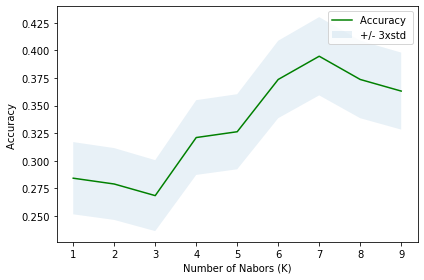

In [20]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [21]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.39473684210526316 with k= 7
